#Risk

This notebook presents 

Copyright 2015 Allen Downey

MIT License: http://opensource.org/licenses/MIT

In [15]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
import thinkbayes2
import thinkplot

import statsmodels.formula.api as smf

%matplotlib inline

In [16]:
df = pd.read_excel('helmus10yrfixed.xlsx')
df['recid'] = df['10-yr recidivate']
df.head()

,score,10-yr recidivate,recid
0,-2,0,0
1,-2,0,0
2,-1,0,0
3,-1,0,0
4,-1,0,0


In [33]:
df.tail()

,score,10-yr recidivate,recid
699,10,1,1
700,10,1,1
701,10,1,1
702,11,0,0
703,NaN,204,204


In [34]:
df = df.dropna()
df.tail()

,score,10-yr recidivate,recid
698,10,1,1
699,10,1,1
700,10,1,1
701,10,1,1
702,11,0,0


In [35]:
formula = 'recid ~ score'
model = smf.logit(formula, data=df)
results = model.fit(disp=False)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  recid   No. Observations:                  703
Model:                          Logit   Df Residuals:                      701
Method:                           MLE   Df Model:                            1
Date:                Mon, 02 Nov 2015   Pseudo R-squ.:                 0.03919
Time:                        15:48:00   Log-Likelihood:                -406.84
converged:                       True   LL-Null:                       -423.43
                                        LLR p-value:                 8.371e-09
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.8129      0.194     -9.335      0.000        -2.194    -1.432
score          0.2048      0.037      5.534      0.000         0.132     0.277
==============================================================================
"""

In [53]:
odds = np.exp(results.fittedvalues)
ps = odds / (1 + odds)
ps

0      0.097754
1      0.097754
2      0.117359
3      0.117359
4      0.117359
5      0.117359
6      0.117359
7      0.117359
8      0.117359
9      0.117359
10     0.117359
11     0.117359
12     0.117359
13     0.117359
14     0.117359
15     0.117359
16     0.117359
17     0.117359
18     0.117359
19     0.117359
20     0.117359
21     0.117359
22     0.117359
23     0.117359
24     0.117359
25     0.117359
26     0.140284
27     0.140284
28     0.140284
29     0.140284
         ...   
673    0.456382
674    0.456382
675    0.456382
676    0.507458
677    0.507458
678    0.507458
679    0.507458
680    0.507458
681    0.507458
682    0.507458
683    0.507458
684    0.507458
685    0.507458
686    0.507458
687    0.507458
688    0.507458
689    0.507458
690    0.507458
691    0.507458
692    0.507458
693    0.558379
694    0.558379
695    0.558379
696    0.558379
697    0.558379
698    0.558379
699    0.558379
700    0.558379
701    0.558379
702    0.608101
dtype: float64

In [58]:
class BLogit(thinkbayes2.Suite, thinkbayes2.Joint):
    
    def Likelihood(self, df, hypo):
        slope, inter = hypo
        log_odds = df.score * slope + inter
        odds = np.exp(log_odds)
        ps = odds / (1 + odds)
        likes = ps * df.recid + (1-ps) * (1-df.recid)
        like = np.prod(likes)
        return like

In [59]:
blogit = BLogit()

In [60]:
slope, inter = (results.params['score'], results.params['Intercept'])
slope, inter

(0.20475163024127738, -1.8129301177982706)

In [61]:
log_odds = df.score * slope + inter
odds = np.exp(log_odds)
ps = odds / (1 + odds)
likes = ps * df.recid + (1-ps) * (1-df.recid)
likes

0      0.902246
1      0.902246
2      0.882641
3      0.882641
4      0.882641
5      0.882641
6      0.882641
7      0.882641
8      0.882641
9      0.882641
10     0.882641
11     0.882641
12     0.882641
13     0.882641
14     0.882641
15     0.882641
16     0.882641
17     0.882641
18     0.882641
19     0.882641
20     0.882641
21     0.882641
22     0.882641
23     0.882641
24     0.117359
25     0.117359
26     0.859716
27     0.859716
28     0.859716
29     0.859716
         ...   
673    0.456382
674    0.456382
675    0.456382
676    0.492542
677    0.492542
678    0.492542
679    0.492542
680    0.492542
681    0.492542
682    0.492542
683    0.492542
684    0.492542
685    0.507458
686    0.507458
687    0.507458
688    0.507458
689    0.507458
690    0.507458
691    0.507458
692    0.507458
693    0.441621
694    0.441621
695    0.441621
696    0.441621
697    0.441621
698    0.558379
699    0.558379
700    0.558379
701    0.558379
702    0.391899
dtype: float64

In [62]:
hypo = (slope, inter)
blogit.Likelihood(df, hypo)

2.0587276874515058e-177

In [63]:
hypos = [(slope, inter) for slope in np.linspace(0, 0.4, 101)
                        for inter in np.linspace(-3, 0, 101)]

In [64]:
blogit = BLogit(hypos)

In [65]:
blogit.Update(df)

3.3351012535668754e-179

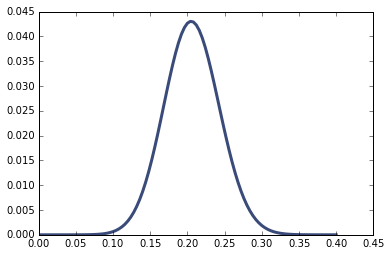

In [66]:
pmf_slope = blogit.Marginal(0)
thinkplot.Pdf(pmf_slope)

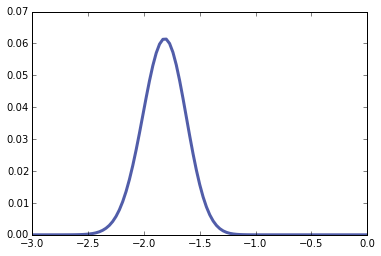

In [67]:
pmf_inter = blogit.Marginal(1)
thinkplot.Pdf(pmf_inter)

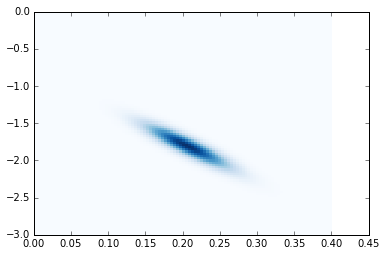

In [69]:
thinkplot.Contour(blogit, pcolor=True, contour=False)

In [82]:
def make_predictive(blogit, score):
    pmf = thinkbayes2.Pmf()
    for (slope, inter), prob in blogit.Items():
        x = score * slope + inter
        o = np.exp(x)
        p = o / (1+o)
        pmf[p] = prob
    return pmf

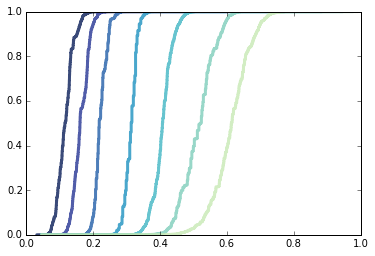

In [83]:
scores = [-1, 1, 3, 5, 7, 9, 11]
thinkplot.PrePlot(len(scores))
for score in scores:
    pmf = make_predictive(blogit, score)
    thinkplot.Cdf(pmf.MakeCdf())

In [75]:
make_predictive(blogit, 0)

UnboundLocalError: local variable 'x' referenced before assignment